# A/B tests

## Goal:

1. Are people more likely to form a mutual relationship with the push notification?

2. Does the mutual relationship form more quickly with the push notification? 

> The experiment runs from 2017-12-12 00:00:00 to 2018-01-08 23:59:59.

In [1]:
import pandas as pd
from scipy.stats import ttest_ind 
from scipy.stats import chi2_contingency
from scipy.stats import mannwhitneyu
import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np

In [2]:
analytics = pd.read_csv("./data/clean_analytics.csv")

In [3]:
analytics.head()

,user_A,user_B,event_start,event_end,assignment
0,c8501e4e-7914-411b-9d0c-96a3180d0daa,4380277a-5cb8-42d7-8b21-2a7daba6906f,1.516901e+09,1.516907e+09,Other
1,1b906005-3fc7-44df-a93f-cc7afdf11bd4,6427b7f4-9223-4bfb-8d9b-e19abeeb387e,1.516901e+09,NaN,Other
2,36cbbb08-5794-43f2-92d1-c6313ac355f8,c8270f60-5ce2-4df0-9487-eb6fd1ca2369,1.516814e+09,1.516901e+09,Other
3,329d3d52-ce78-4d3a-8a91-f765a31e0319,5d1a38a1-39ce-4640-8c3c-bb010e9a64ab,1.514399e+09,1.514410e+09,Experiment
4,82f959c6-559d-4d51-8323-0c41a0741f4a,de77a7b7-b2af-4738-9d3b-4948d23f0f57,1.514410e+09,1.514739e+09,Control


The time used to form a mutual relationship needs to be computed first.

In [4]:
analytics['time_used'] = analytics['event_end'] - analytics['event_start']

Double check if any value in `time_used` column is smaller than 0.

In [5]:
na_index = analytics['time_used'].notna() 
(analytics.loc[na_index,"time_used"]<0).sum()

0

The number of events assgined to experiment, control and other group are

In [6]:
analytics['assignment'].value_counts()

Other         148380
Control       111963
Experiment     52450
Name: assignment, dtype: int64

## Hypothesis testing 1

> Are people more likely to form a mutual relationship with the push notification? 

1. Define `p1` to be the percentage of users that received the push notification and then formed a mutual relationship.

2. Define `p2` to be the percentage of users that did not received the push notification but formed a mutual relationship.  

`Null hypothesis: p1 and p2 are independent of experiment/control group split (p1 = p2)`

`Alternative hypothesis: p1 and p2 are not independent of experiment/control group split (p1 not equal p2)`

The type-I error rate is set to a standard 5%. 

**Discussion**: The chi-square indepedence test will be used here instead of the usual t-test. 

The assumption of the chi-squared test:
1. The independency of observations. 
2. Large enough observations for the test statistic to approach chi-squared distribution (n>50)

The t-test requires the underlying disitrbution to be a normal distribution, but a pecentage only takes value between 0 and 1. Thus, it is not ideal to use t-test on percentage. 
Given we have more than 50 observations, the Chi-square test of independence is a more apporpriate choice here. 

### computing the frequency of observations. 

In [7]:
control_index = analytics['assignment'] == "Control"
experiment_index = analytics['assignment'] == "Experiment"

mutual_index = analytics['event_end'].notna()
none_index = analytics['event_end'].isna()

In [8]:
experiment_mutual = analytics.loc[experiment_index & mutual_index].shape[0]
experiment_none = analytics.loc[experiment_index & none_index].shape[0]

control_mutual =  analytics.loc[control_index & mutual_index].shape[0]
control_none = analytics.loc[control_index & none_index].shape[0]

In [9]:
obs = [[experiment_mutual,control_mutual ],[experiment_none, control_none]]

In [10]:
chi2, p, dof, ex = chi2_contingency(obs, correction=True)

In [11]:
p

2.6627168439718216e-16

### The p-value for this independence test is  much smaller than 0.05.

**The null hypothesis is rejected.**

This means that the push notification has an effect on porportions of the mutual relationship formed. 

In [12]:
experiment_percentage = experiment_mutual/ (experiment_mutual + experiment_none)
experiment_percentage

0.5525834127740705

In [13]:
control_percentage = control_mutual/(control_mutual + control_none)
control_percentage

0.5309700526066647

The experiment group has `55.25%` of users that formed the mutual relationship, while the control group has a  `53.09%` of users that formed the mutual relationship. 

In [14]:
(experiment_percentage - control_percentage)/control_percentage

0.04070542220093279

There is about 4.07% percent increase of proportions in forming a mutual relationship. 

The number of observations are much larger than 1000. The `power of the test is higher than the standard 0.8`.

I suspect that push notification has a negative effect on users that have a lot of followers and a positive effect on users that have less followers in forming the mutual relationship. Further analysis will be needed for this. 

## Hypothesis test 2

> Does the mutual relationship form more quickly with the push notification? 

Define `t1` to be the average time used for a user in experiment group to form a mutual relationship.

Define `t2` to be the average time used for a user in control group to form a mutual relationship. 

`Null hypothesis: t1 = t2`

`Alternative hypothesis: t1 < t2`

The type-I error rate is set to a standard 5%. 


**Discussion**: The goal here is to see if the mean of the time used to form a mutual relationship differs in control and experiment group. A t-test comparing the means of two independent samples is a natural choice here. 

Assumptions of t-test: 
1. Mean of the two populations compared should follow a normal distribution. 
2. The data are independently sampled. 

Given the large size of observations available and the central limit theorem, the mean should follow the normal distribution. 

The actual test used is the `Welch's t test`, which deals with unequal variance in the two populations. 


In [15]:
control_index = analytics['assignment'] == "Control"
experiment_index = analytics['assignment'] == "Experiment"

notna_index = analytics['time_used'].notna()

In [16]:
experitment_time = analytics.loc[experiment_index & notna_index, "time_used"].values
control_time = analytics.loc[control_index & notna_index, "time_used"].values

In [17]:
stats, p = ttest_ind(experitment_time, control_time, equal_var=False)

In [18]:
p

2.0634064855014137e-08

The p-value here is the p-value for two-sided test and the hypothesis we are testing is the one-sided test. The p-value for one sided test is half of the two-sided test. 

The p-value for our hypothesis test is 

In [19]:
p/2

1.0317032427507068e-08

### The p-value for this test is  much smaller than 0.05.

**The null hypothesis is rejected.**

This means that the push notification shortened the time used for forming a mutual relationship. 

In [20]:
experitment_time.mean()

322717.17182486283

In [21]:
control_time.mean()

347005.13697454962

In [22]:
(experitment_time.mean() -control_time.mean() )/control_time.mean()

-0.069993099702924971

## There is a 6% decrease in average time used to form a mutual relationship.

(0, 369317.05474623205)

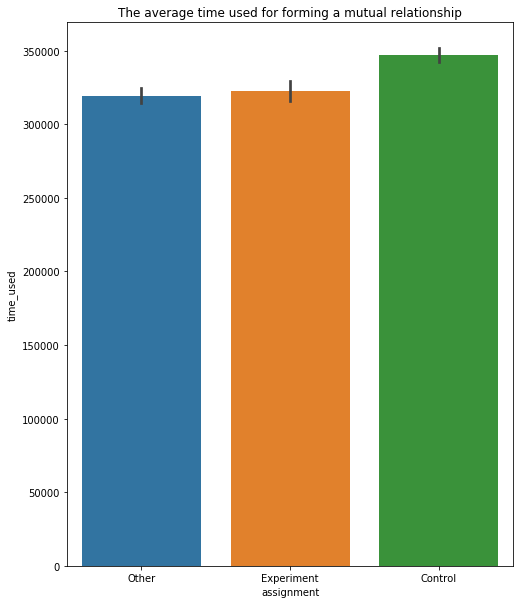

In [23]:
plt.figure(figsize = (8,10))
sns.barplot(x = "assignment", y= "time_used" , data = analytics)
plt.title("The average time used for forming a mutual relationship");
plt.ylim(0)

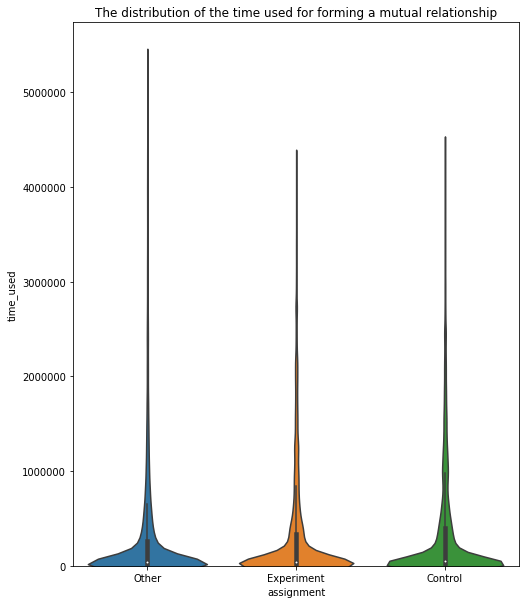

In [31]:
plt.figure(figsize = (8,10))
sns.violinplot(x = "assignment", y= "time_used" , data = analytics);
plt.title("The distribution of the time used for forming a mutual relationship");
plt.ylim(0);

The underlying distribution of the time used is highly non-normal. This could leads to a spurious statistical significance due to the slow convergence of the distribution of the mean to a normal distribution. With this concern, a Wilcoxon rank-sum test should be performed. 

## Hypothesis testing 3


`Null hypothesis: The distribution of time used in forming a mutual relationship is the same for control and experiment group. `

`Alternative hypothesis:  The distribution of time used in forming a mutual relationship is not the same for control and experiment group. `

The type-I error rate is set to a standard 5%. 


Assumptions of the Wilcoxon rank-sum test: Data is indepedently sampled.

This test does not reuqire that the distributiobn of the mean is a normal distribution.

In [25]:
stats, p = mannwhitneyu(experitment_time, control_time, alternative = "two-sided")

In [26]:
p

3.1740204237231786e-19

This confirms that the statistical significance from the t-test is not a spurious one. 

The median of the time used is also different for control and experiment group.

In [27]:
np.median(experitment_time)

42781.0

In [28]:
np.median(control_time)

53905.0

In [29]:
(np.median(experitment_time) - np.median(control_time))/np.median(control_time)

-0.2063630460996197

## There is a 20% decrease in the median of time used to form a mutual relationship in the experiment group compared to the control group.

The estimation of the power of Wilcoxon rank-sum test is a whole simulation study topic. Empirically, it is different from the power of t-test by 5% to 10%. Given the large number of observations, it can be safely assumed that the power of the Wilcoxon rank-sum test is higher than the standard 0.8. 

# Conclusion:


## 1. Are people more likely to form a mutual relationship with the push notification? `Yes`

 ## 2. Does the mutual relationship form more quickly with the push notification? `Yes`